# Experiment Design Lecture 1: Overview of Experiment Design and Surrogate Models

## The Problem Statement

The purpose of experiment design is to study the effects of various inputs on the outputs of a system, and use the resulting data to construct a simplified statistical model of what is happening in the system to make predictions faster and to better control and optimize the system.

For a given system, we start by selecting the inputs and outputs that we think are important, with input and feedback from experts with field experience.

The real system is represented as a map from one set (inputs) to the other (outputs), the real function $f$:

$$
Y = f(X)
$$

where capital leters denote vector quantities $X$ and $Y$, and we are creating a surrogate model (sometimes called a metamodel, as it is a model of a model) called $g$:

$$
Y = g(X)
$$

The objective is to construct $g(X)$ and assess how good a job it does of representing the real function $f(X)$. 

The purpose of experiment design that we will discuss in these lecture notes is to create a cheap representation of an expensive computer model, but these techniques apply to the creation of any metamodel that is intended to represent the behavior of a more complex model.

## Classes of Surrogate Models

There are several classes or forms for the metamodel $g$ to take, using different methods of gathering data about $f$:

* Space filling designs
* Uniform sampling
* Nueral networks
* Gaussian 
* Polynomials (repsonse surfaces)
* General linear models

These lecture notes will not cover all - only space-filling designs and resopnse surface methodologies.

# Surrogate Modeling

## Basic Concepts for Experiments

As we'll see, experiment design techniques and reduced order models are closely related to statistal tests and analysis of variance (ANOVA) tests.

## Basic Concepts for Metamodeling

Metamodeling: regression on data without random error.

We are trying to predict the true value of our real function $f(X)$ using a surrogate model $g(X)$.

The most common measure of error in a metamodel is mean square error:

$$
\mbox{MSE}(g) = \int_{\Omega} \left( f(X) - g(X) \right)^2 dX
$$

where $\Omega$ is the domain of the problem (the entire region of input vector space $X$ where the surrogate model or metamodel should apply).

### Example

Let's look at an example of a real function and a polynomial metamodel. We'll start simple: the real function is

$$
f(x) = sin(x)
$$

and the surrogate model is

$$
g(x) = x - \dfrac{1}{3!} x^3 + \dfrac{1}{5!} x^5 - \dfrac{1}{7!} x^7 + \dfrac{1}{9!} x^9
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from scipy.special import factorial

In [2]:
%matplotlib inline

In [3]:
x_left = 0.0
x_right = np.pi
Npoints = 100

x = np.linspace(x_left, x_right, Npoints)

In [4]:
def f(x):
    """Returns 
    f(x) = sin( x )
    """
    return np.sin(x)

To get an approximate polynomial model for the function in the neighborhood of $[0,\pi]$, we can use a Taylor series approximation about a point $x_0 = 0$:

In [5]:
def g(x):
    """Returns a surrogate function for f(x),
    using the classic Taylor approximation,
    
        sin(x) ~ x - 1/3! x^3 + 1/5! x^5 - 1/7! x^7 + ...
    """
    # Perform Taylor series expansion about x = 0
    x0 = 0
    dx = x - x0
    dim = np.shape(dx)[0]
    result = np.zeros(dim,)
    for i in range(dim):
        dxi = dx[i]
        val = dxi
        val -= (1/factorial(3))*pow(dxi,3)
        val += (1/factorial(5))*pow(dxi,5)
        val -= (1/factorial(7))*pow(dxi,7)
        val += (1/factorial(9))*pow(dxi,9)
        result[i] = val
        
    return result

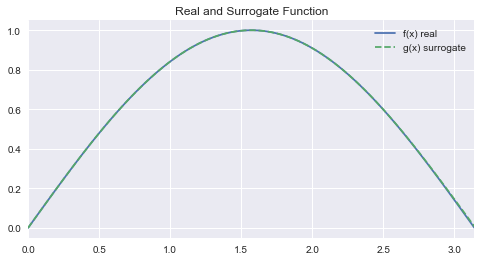

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(x,f(x),'-',  label='f(x) real')
ax.plot(x,g(x),'--', label='g(x) surrogate')

ax.set_title('Real and Surrogate Function')
ax.set_xlim([min(x),max(x)])
ax.legend()
plt.show()

In [7]:
def SE(x, r, s):
    """Evaluate the square error vector:
        ( f(x) - g(x) )^2         
    """
    se = (r-s)**2
    return se

def MSE(x, r, s):
    """Evaluate the numerical integral of the 
    mean squared error:
    
        \int ( f(x) - g(x) )^2 dx
        
    f(x) = r = real
    g(x) = s = surrogate
    """
    se = SE(x, r, s)
    mse = np.mean(se)
    return mse

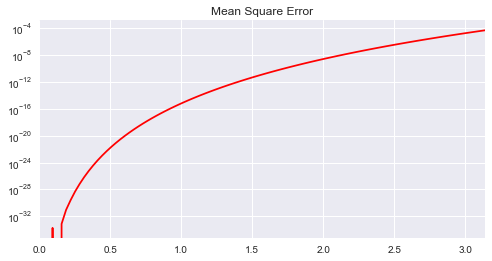

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.semilogy(x,SE(x,f(x),g(x)),'r-')

ax.set_title('Mean Square Error')
ax.set_xlim([min(x),max(x)])
plt.show()

In [9]:
print(MSE(x, f(x), g(x)))

2.33340411846e-06


## Latin Hypercube

One of the strategies for constructing a surrogate model $g(X)$ to represent a real function $f(X)$ is to pick points in $X$ space that will effectively cover the entire input parameter space $\Omega$.

Due to something called the **curse of dimensionality**, the amount of input space that must be covered grows geometrically with the number of input parameters, so that it quickly becomes impossible to efficiently sample the input paramter space $X$.

However, for two-dimensional or low-dimensional systems, random sampling of the input space using Latin hypercube can be effective. 

Latin hypercube sampling selects a set of input samples that fulfill a constraint: namely, that when they are projected onto each input dimension, the sample points are evenly distributed.

To illustrate in two dimensions: suppose we have a system with two input variables ranging from 0 to 1, and we want to understand the effect they have on the response of the system. Further suppose that we're willing to run 15 experiments, and no more.

In [10]:
Ne = 15
xlo = 0
xhi = 1

x1 = np.linspace(xlo, xhi, Ne)
x2 = x1.copy()

We will pre-select our 15 values of x1, and our 15 values of x2, and then randomly pair them up using a Knuth shuffle.

In [11]:
from copy import copy

def knuth_shuffle(x):
    n = len(x)
    for i in reversed(range(n)):
        if i==0:
            break
        
        # random index includes i (no shuffle)P
        randix = np.random.randint(0,i+1)
        
        temp = x[randix]
        x[randix] = x[i]
        x[i] = temp
        
    return x

In [12]:
for i in range(10):
    print(knuth_shuffle([2,4,6,8,10]))

[8, 4, 10, 2, 6]
[4, 10, 2, 6, 8]
[4, 10, 6, 8, 2]
[10, 2, 6, 4, 8]
[10, 4, 2, 6, 8]
[8, 6, 10, 2, 4]
[2, 6, 10, 8, 4]
[4, 10, 6, 8, 2]
[8, 10, 2, 6, 4]
[10, 8, 2, 4, 6]


In [13]:
pprint(list((x1_, x2_) for (x1_, x2_) in zip(x1, x2)))

[(0.0, 0.0),
 (0.071428571428571425, 0.071428571428571425),
 (0.14285714285714285, 0.14285714285714285),
 (0.21428571428571427, 0.21428571428571427),
 (0.2857142857142857, 0.2857142857142857),
 (0.3571428571428571, 0.3571428571428571),
 (0.42857142857142855, 0.42857142857142855),
 (0.5, 0.5),
 (0.5714285714285714, 0.5714285714285714),
 (0.64285714285714279, 0.64285714285714279),
 (0.71428571428571419, 0.71428571428571419),
 (0.7857142857142857, 0.7857142857142857),
 (0.8571428571428571, 0.8571428571428571),
 (0.92857142857142849, 0.92857142857142849),
 (1.0, 1.0)]


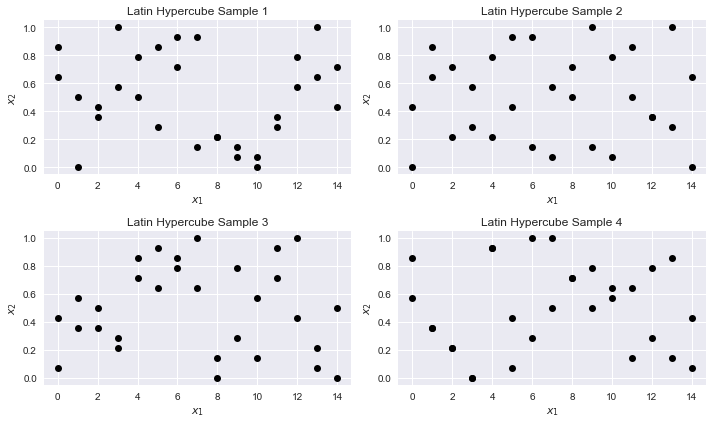

In [14]:
fig = plt.figure(figsize=(10,6))

axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

axs = np.ravel(axs)

for i, ax in enumerate(axs):
    
    x1s = knuth_shuffle(x1)
    x2s = knuth_shuffle(x2)
    pairs = [(c1, c2) for (c1,c2) in zip(x1s,x2s)]

    ax.plot(pairs, 'o', color='black')

    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_title(r'Latin Hypercube Sample %d'%(i+1))

plt.tight_layout()
plt.show()

For a domain divided into $N$ bins (15 in the example above), there are exactly 15 samples taken, and each bin has an equal marginal probability of being sampled by a particular sample of $\frac{1}{N}$.

### Algorithm

The purpose of this algorithm is to create an experimental design with $N$ samples to be taken from the real function $f(X)$ for an input vector dimensionality of $p$.

The result should be a Latin hypercube design that is an $n \times p$ matrix denoting the variable combinations at which to sample.

**Step 1:** Take $p$ independent permutations of $n$ integers $\pi_j(1) \dots \pi_j(n)$ (note that $j$ indexes the dimension of the Latin hypercube $j = 1 \dots p$, and $n$ is the number of samples.

**Step 2:** Take $ns$ random numbers $U_{k}^{j}$ and compute the locations of the Latin hypercube samples as:

$$
x_{k}^{j} = \dfrac{ \pi_j(k) - U_{k}^{j} }{n}
$$

where $k = 1 \dots n$ and $j = 1 \dots p$.

### Variation

One variation on this idea is *centered* Latin hypercube sampling.

Each sample location is given by:

$$
x_{k}^{j} = \dfrac{ \pi_j(k) - 0.5 }{n}
$$

where $k = 1 \dots n$ indexes which experiment, or sample. Note that this technique does not require random numbers.

### Latin Hypercube Sampling in Matlab

In Matlab, the statistical toolbox has a function called `lhsdesign(n,p)` that performs a Latin hypercube sampling design for $n$ samples and $p$ variables.

### Latin Hypercube Sampling in Python

We can assemble the code above to create a basic `lhsdesign(n,p)` function that assumes that each variable is normalized (distributed between 0 and 1):

In [15]:
def lhsdesign(n,p):
    lo = 0
    hi = 1
    result = np.zeros((n,p))
    for i in range(p):
        seq = np.linspace(lo, hi,n)
        seq_shuff = knuth_shuffle(seq)
        result[:,i] = seq_shuff
    return result

The basic method, then, to construct a Latin hypercube sampling procedure with $n$ samples of $p$ dimensions is to construct and return an $n \times p$ matrix of numbers.

The result is a sequence of values for each of the independent variables $x_i, i=1 \dots 5$. If we plot projections of the samples into various subspaces, we can confirm the samples are randomly distributed. One red sample is highlighted across all plots for illustrative purposes.

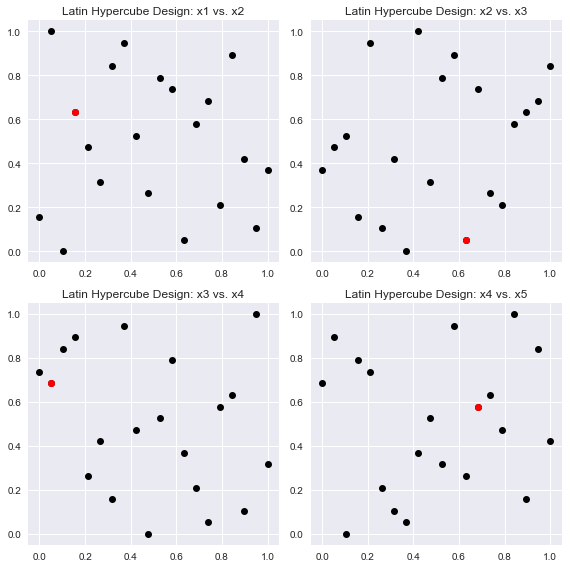

In [16]:
# 5-dimensional latin hypercube with 20 points
lh = lhsdesign(20,5)

fig = plt.figure(figsize=(8,8))
ax1, ax2, ax3, ax4 = [fig.add_subplot(2,2,i+1) for i in range(4)]

ax1.plot(lh[:,0],lh[:,1],'ko')
ax1.plot(lh[1,0],lh[1,1],'ro')
ax1.set_title("Latin Hypercube Design: x1 vs. x2")

ax2.plot(lh[:,1],lh[:,2],'ko')
ax2.plot(lh[1,1],lh[1,2],'ro')
ax2.set_title("Latin Hypercube Design: x2 vs. x3")

ax3.plot(lh[:,2],lh[:,3],'ko')
ax3.plot(lh[1,2],lh[1,3],'ro')
ax3.set_title("Latin Hypercube Design: x3 vs. x4")

ax4.plot(lh[:,3],lh[:,4],'ko')
ax4.plot(lh[1,3],lh[1,4],'ro')
ax4.set_title("Latin Hypercube Design: x4 vs. x5")

plt.tight_layout()
plt.show()

### Discussion Question

Consider the same `lhsdesign` function defined above, but with the Knuth shuffle removed:

In [17]:
def bad_lhsdesign(n,p):
    lo = 0
    hi = 1
    result = np.zeros((n,p))
    for i in range(p):
        seq = np.linspace(lo, hi,n)
        #seq_shuff = knuth_shuffle(seq)
        result[:,i] = seq
    return result

This results in a non-random hypercube design, as shown below:

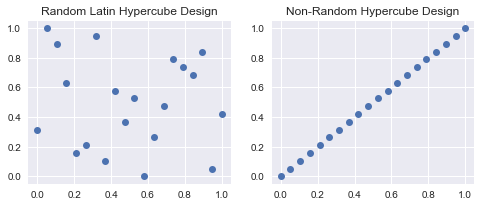

In [18]:
# 5-dimensional latin hypercube with 20 points
lh_g = lhsdesign(20,2)
lh_b = bad_lhsdesign(20,2)

fig = plt.figure(figsize=(8,3))
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]

ax1.plot(lh_g[:,0],lh_g[:,1],'o')
ax2.plot(lh_b[:,0],lh_b[:,1],'o')

ax1.set_title("Random Latin Hypercube Design")
ax2.set_title("Non-Random Hypercube Design")

plt.show()

**Question for discussion:** why might the LHS sample on the left be better than the more predictable sampling on the right?

**Activity:** After discussing why the design on the left would be better than the design on the right, pick a physical system and come up with an example of an effect that would be missed by the design on the left.

## Monte Carlo Sampling

<img src="https://charlesreid1.com/w/images/d/dd/Roulette.jpg" alt="Roulette wheel" width="300px">

**Roulette illustrates the random nature of the samples that are chosen in a Monte Carlo method. Good random number generators (for example, a roulette wheel) are not particularly fast; Monte Carlo techniques require thinking about this tradeoff.**

Monte Carlo sampling is essentially a brute-force technique in which random samples are taken until confidence that the entire space has been sampled is satisfactory.

Random numbers are used to create sampling points in each direction.

Think of Monte Carlo ray-tracing: you send out a whole bunch of rays, each in random directions, and from the result you determine the radiative flux. Mathematically, you're performing an integration by randomly sampling the function you want to integrate, then adding up all of the random samples: 

$$
\int f(x) dx \approx \dfrac{1}{N} \sum_{i} f(x_i)
$$

### Discussion Question

**Discussion Question:** Monte Carlo and Latin hypercube are both random sampling methods. How are they different? Why would we use Monte Carlo sampling instead of Latin hypercube sampling?

## Response Surfaces

See below.

# Response Surface Methodology

The response surface methodology (RSM) for experimental design and surrogate model construction utilizes low-order polynomials to approximate the response surface. 

The idea of using polynomials is motivated by the observation that in complex systems, integrated system response quantities (e.g., a time-integrated flux through an area) are often smooth with respect to the input parameters.

For a function $f(X)$, the response surface is the parameter-space plot of the output fnction $f$ as a function of the input paramter vector $X$. 

(Example response surface of output product yield as function of mixing length and rate constant)

The response surface methodology prescribes ways to sample the output function $f(X)$ in order to produce the best polynomial representation $g(X)$ possible.

## Terminology

A **factor** refers to a particular input variable $x_i$.

A **level** is a discrete value that a parameter $x_i$ can take on. If $x_i$ is continuous, these are the variable set-points that are used for the experiment.

For example: if I want to investigate the effect of the mixing length $L_{mix}$ on the output product concentration $y_P$, I have to decide on discrete values of $L_{mix}$ to try.

If I choose the three values of $0.1$, $1.0$, and $10.0$, then $L_{mix}$ has three levels $0.1,1.0,10.0$.

## Factorial Design

Factorial designs are experimental designs for model functions $g(X)$ that are linear functions of input parameters. That is, they assume a linear model (given a $p$-dimensional input parameter vector) of the form:

$$
Y(X) = a_0 + \sum_{i=1}^{p} a_i x_i 
+ \sum_{j=1}^{p} \sum_{k=1}^{j} a_{jk} x_j x_k
+ \dots
$$

### One Factor At A Time (OFAAT)

One factor at a time (OFAAT) testing ignores the interaction effects of each variable, assuming each is independent of others.

The algorithm is as follows:

Given: a set of $k$ factors $i = 1 \dots k$.

**Step 1:** Fix the levels of all but one factor $i = 2, 3, \dots, k$ and determine the optimal level for the factor $i=1$

**Step 2:** Use the optimal level for factor $i=1$. Fix the levels for all but one factor $i=3, 4, \dots, k$ and determine the optimal level for factor $i=2$.

**Step 3:** Use the optimal level for factor $i=1,2$. Fix levels for all but one factor $i = 4, 5, \dots, k$, etc.

### Full Factorial Design

The following discussion assumes the use of two factor levels. Using more than two factor levels can potentially make factorial experimental design complicated (more on this topic later).

Full factorial algorithm is as follows:

**Step 1:** Assign the value $+1$ or $-1$ to the upper and lower factor levels, respectively.

**Step 2:** Crate a table of factor-level combinations. For example:

| Enumeration | Factor 1 | Factor 2 |
|-------------|----------|----------|
| 1           | +1       | +1       |
| 2           | +1       | -1       |
| 3           | -1       | +1       |
| 4           | -1       | -1       |

**Step 3:** Generate a sequence of $N$ random numbers, where $N$ is the number of factor-level combinations.

**Step 4:** Run each sequence in the determined order.

The cost of a full factorial design with 2 levels for each of the $k$ factors is $2^k$ function samples.

### Fractional Factorial Design

Fractional factorial designs reduce the number of experimental runs required to construct the polynomial, but they throw out some information about interaction effects. Typically, information about the highest-order effects is thrown out.

The essential technique is to determine which experiments you do not want to run, and exclude those from Step 4 in the factorial design algorithm given above. And the essential technique for determining which experiments you do not want to run is to determine which combination of experiments will give information about higher-order interaction effects.

To do this, an expanded version of the above table is required: one that includes factor interactions. To determine, for example, the factor interaction between factors 1 and 2, $I_{12}$, simply multiply the factor 1 and factor 2 values (for example, $+1 \times +1$ or $-1 \times +1$, etc.).

Factor 1 = $I_1$

Factor 2 = $I_2$

Factor 3 = $I_3$

Factor 1-Factor 2 Interaction = $I_{12}$

Factor 2-Factor 3 Interaction = $I_{23}$

Factor 1-Factor 3 Interaction = $I_{13}$

Factor 1-2-3 Interaction = $I_{123}$

| Enumeration | $I_1$ | $I_2$ | $I_3$ | $I_{12}$ | $I_{23}$ | $I_{13}$ | $I_{123}$ |
|-------------|-----|-----|-----|--------|--------|--------|---------|
| 1           | +1  | +1  | +1  | +1     | +1     | +1     | +1      |
| 2           | +1  | +1  | -1  | +1     | -1     | -1     | -1      |
| 3           | +1  | -1  | +1  | -1     | -1     | +1     | -1      |
| 4           | +1  | -1  | -1  | -1     | +1     | -1     | +1      |
| 5           | -1  | +1  | +1  | -1     | +1     | -1     | -1      |
| 6           | -1  | +1  | -1  | -1     | -1     | +1     | +1      |
| 7           | -1  | -1  | +1  | +1     | -1     | -1     | +1      |
| 8           | -1  | -1  | -1  | +1     | +1     | +1     | -1      |

The cost of a $\dfrac{1}{p}$ fractional factorial design with 2 levels for each of the $k$ factors is $2^{k-p}$ function samples. (Recall the cost of a full k-factorial was $2^{k}$).)

The cost of a fractional factorial is lower. The tradeoff is that information about higher-order interaction terms is lost. In practice, this means that the model is forced to convolute interaction terms, so that you only know that interaction term 1 and/or interaction term 2 caused an effect.

## Composite Design

Composite design builds on the full factorial design by adding three additional levels. Rather than just $-1$ and $+1$, composite design also includes $-2, 0, +2$.

Thinking about a three-dimensional factorial design, the factorial design sample points looks like a cube in parameter space. Composite design makes a "star" design.

The additional sample points consist of the new lower $-2$ and upper $+2$ levels for each factor, while keeping all other factors constant at the 0 level. It also includes a center point, at which all factors have a factor level of 0.

For a two-parameter experimental design, this looks like: 

| Experimental Design Step | Factor 1 | Factor 2 |
|--------------------------|----------|----------|
| Full factorial           | +1       | +1       |
| Full factorial           | +1       | -1       |
| Full factorial           | -1       | +1       |
| Full factorial           | -1       | -1       |
| Composite                | 0        | 0        |
| Composite                | +2       | 0        |
| Composite                | -2       | 0        |
| Composite                | 0        | +2       |
| Composite                | 0        | -2       |

The cost of a composite design (5 levels) for each of $k$ factors is $2^{k+1} + 1$ samples of the function $f(X)$.

## Other Alternatives

### Box Behnkin Designs

Box-Behnkin designs are intended to minimize the number of function evaluations required to construct a response surface (polynomial surrogate model). The design consists of three levels, rather than the five required by composite designs.

For more information see Box Behnken (1960).

### Plackett Burman Designs

Experimental designs requiring a very minimal number of sample points.

## Sequential Assembly

We already showed how we can perform a composite experimental design in two steps: starting with a factorial, assessing the results, and continuing with further samples to complete a composite design.

This idea can be extended further, to the factorial design.

### The Idea

We use the fact that any fractional (or full) factorial design at level $k$ requiring $2^k$ samples can be broken into two $k+1$ fractional factorial designs consisting of $2^{k-1}$ samples each. These fractional factorial designs can themselves yield useful information about main and interaction effects, allowing analysis to take place before the $k$ fractional factorial design is completed.

Thus, a full factorial is broken into two half factorial designs; the half factorial designs are broken into two quarter-factorial designs; and so on, until a screening design scheme is reached.

### Why Sequential Assembly

There are two motivations to use sequential assembly to create the response surface.

**The first is to encourage exploration of more variables.** Remember that we have to keep the total number of samples of $f(X)$ reasonable, while also trying to maximize the nmber of input variables we explore so as to pick the best ones. If an entire composite experimental design is being carried out in one go, adding an additional input variable can greatly increase the amount of data needed.

This leads to *a priori* pruning of input variables considered important - but these should be included so the model itself can reveal which factors are important.

Sequential assembly allows for exploring more factors at the initial stages of the experimental design, and pruning the list of unimportant variables as we go.

**The second is to stop early.** By analyzing the results as they come in, during intermediate steps of the experiment design, we aren't "flying blind" and can make adjustments to the design as we go. 

### Illustrative Example

Let's illustrate screening designs with a simple scenario.

Suppose you are creating a surrogate model $g(X)$ for a real function $f(X)$. Further suppose your experiment design specifies the form of $g(X)$ as a complicated third-order, five-dimensional polynomial, and prescribes 256 experiments to gather data to fit the coefficients of $g(X)$. After slaving away for two months in the lab, you finally have all 256 data points, and sit down to analyze the response surface.

You find out that four of the variables have linear relations, meaning the coefficients of their quadratic and cubic terms were not necessary. Further, you find out that one of the variables had no effect and should not have been included in the factorial design to begin with. The results wasted a lot of time in the lab and resources running experiments. What could you do differently, to raise warnings earlier?

Start the experiment design with a Plackett-Burman screening design and use a large number of possibly important factors. This aliases main and interaction effects, so we would have to take the results with a grain of salt, but the tradeoff is the number of data points is equal to the number of factors (very cheap).

From there, we would create a computational and uncertainty budget to decide how many factors to explore and how well they must be characterized (which also depends on the quality of the measured data). 

### The Recipe

Sequential design specifies the recipe we should use:

Stage 1:
* The very first run should be a Plackett-Burman screening design. This type of screening design is very cheap (number of samples equals number of factors) and will yield estimates of main effects for each factor (convoluted with variable interaction effects).
* Examine the results of the Plackett-Burman screening design. Screen out any input variables deemed unimportant.

Stage 2:
* Run the most highly-fractionated factorial design; the exact fraction will depend on the number of input variables. The more input variables, the more highly fractionated the full design can be.
* Examine the results of the first highly-fractionated factorial design. Determine if any main or interaction effects can be ignored or are particularly important. Perform an error analysis to determine how 

(etc...)

Stage N-1:
* Run the full factorial design on all the factors that have survived so far
* Analyze the full factorial results to construct 

## References

### Links to Papers